In [17]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as mpconstants
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
# Input variables as integers
year = 2019
month = 2
start_day = 25
start_hour = 0
end_day = 25
end_hour = 23

# Format the integers into the desired string format
year_month = f'{year}{month:02d}'  # yyyymm
start_time = f'{year}{month:02d}{start_day:02d}{start_hour:02d}'  # yyyymmddhh (start)
end_time = f'{year}{month:02d}{end_day:02d}{end_hour:02d}'  # yyyymmddhh (end)

# Define the URLs for the datasets of the variables we want to download (temperature, geopotential height, humidity, v-wind, u-wind)
urls = {
    'temperature_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_130_t.ll025sc.{start_time}_{end_time}.nc',
    'geopotential_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_129_z.ll025sc.{start_time}_{end_time}.nc',
    'mslp_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc',
    'humidity_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_133_q.ll025sc.{start_time}_{end_time}.nc',
    'v_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_132_v.ll025uv.{start_time}_{end_time}.nc',
    'u_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_131_u.ll025uv.{start_time}_{end_time}.nc',
    'u_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc',
    'v_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc',
    'pv_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_060_pv.ll025sc.{start_time}_{end_time}.nc'  # PV URL
}

# Initialize an empty dictionary to store the datasets
datasets = {}

# Try to load datasets from the URLs
for var, url in urls.items():
    try:
        tds_catalog = TDSCatalog(url)
        ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
        ds = xr.open_dataset(ds_url).metpy.parse_cf()
        datasets[var] = ds
        print(f"Successfully loaded {var}")

    except Exception as e:
        print(f"Error loading {var}: {e}")

# Merge all pressure level datasets into a single Xarray Dataset if they were successfully loaded
try:
    ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['pv_pl']])
    print("Successfully merged pressure level datasets")

except KeyError as e:
    print(f"Error merging pressure level datasets: {e}")

# Merge all surface datasets into a single Xarray Dataset if they were successfully loaded
try:
    ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc']])
    print("Successfully merged surface datasets")
    
except KeyError as e:
    print(f"Error merging surface datasets: {e}")

try:
    # Get the first and last times from the pressure level dataset to slice the surface dataset
    first_time_pl, last_time_pl = ds_pl['time'].min().values, ds_pl['time'].max().values

    # Slice the surface dataset to keep only the times from the first to the last time in ds_pl
    ds_sfc = ds_sfc.sel(time=slice(first_time_pl, last_time_pl))

except KeyError as e:
    print(f"Error accessing 'time' in the datasets: {e}")

except Exception as e:
    print(f"An error occurred during slicing: {e}")


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded geopotential_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded mslp_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded humidity_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded pv_pl
Successfully merged pressure level datasets
Successfully merged surface datasets


In [46]:
def plot_omega(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North']+20, directions['South']-20), longitude=slice(directions['West']-15, directions['East']+15))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m
        q_sliced = ds_pl_sliced['Q'].sel(level=900) * 1000 # units: g/kg

        # MetPy smoothing
        n_reps = 80
        u_sliced_s = mpcalc.smooth_n_point(u_sliced, 9, n_reps)
        v_sliced_s = mpcalc.smooth_n_point(v_sliced, 9, n_reps)
        z_sliced_s = mpcalc.smooth_n_point(z_sliced, 9, n_reps)


        # Selecting
        z_500 = z_sliced_s.sel(level=500)
        z_900 = z_sliced_s.sel(level=900)
        u_g_500, v_g_500 = mpcalc.geostrophic_wind(z_500) * units.meter / units.second
        V_g_500 = mpcalc.wind_speed(u_g_500, v_g_500)
        u_g_900, v_g_900 = mpcalc.geostrophic_wind(z_900) * units.meter / units.second
        V_g_900 = mpcalc.wind_speed(u_g_900, v_g_900)
        u_g, v_g = mpcalc.geostrophic_wind(z_sliced) * units.meter / units.second

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        u_g_500_da = xr.DataArray(u_g_500, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})
        u_g_900_da = xr.DataArray(u_g_900, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})
        v_g_500_da = xr.DataArray(v_g_500, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})
        v_g_900_da = xr.DataArray(v_g_900, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        absolute_vorticity_900 = mpcalc.absolute_vorticity(u_g_900_da, v_g_900_da)
        absolute_vorticity_500 = mpcalc.absolute_vorticity(u_g_500_da, v_g_500_da)

        abs_vort_adv_900 = mpcalc.advection(absolute_vorticity_900, u_g_900_da, v_g_900_da)
        abs_vort_adv_500 = mpcalc.advection(absolute_vorticity_500, u_g_500_da, v_g_500_da)

        differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()

        # Define constants 
        f_0 = 1 * 10**-4 * units('s^-1') # Coriolis parameter
        sigma = 2 * 10**-6 * units('m^2*Pa^-2*s^-2') # Static stability

        # Calculate the omega term A
        omega_term_a = (-(f_0 / sigma) * differential_abs_vorticity_advection)

        # Smoothing the differential vorticity advection
        omega_term_a_smoothed = gaussian_filter(omega_term_a, sigma=5)
        z_500_smoothed = gaussian_filter(z_500, sigma=3)
        z_900_smoothed = gaussian_filter(z_900, sigma=3)

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
        

        isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
        plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(omega_term_a['longitude'], omega_term_a['latitude'], omega_term_a * 10e12, levels=np.arange(-20, 20, 1), cmap=plt.cm.RdYlBu_r, extend='both')
        plt.colorbar(cf, orientation='vertical', label='$10^{12}$ kg·m$^{-3}$·s$^{-3}$', fraction=0.046, pad=0.04)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis QG-$\\omega$ Term A and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

def plot_omega2(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North']+20, directions['South']-20), longitude=slice(directions['West']-15, directions['East']+15))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m

        # Smoothing to reduce noise and focus on the synoptic scale
        n_reps = 50
        u_sliced_s = mpcalc.smooth_n_point(u_sliced, 9, n_reps)
        v_sliced_s = mpcalc.smooth_n_point(v_sliced, 9, n_reps)
        z_sliced_s = mpcalc.smooth_n_point(z_sliced, 9, n_reps)
        t_sliced_s = mpcalc.smooth_n_point(t_sliced, 9, n_reps)

        # Turn the smoothed data into DataArrays
        u_g_500_da = xr.DataArray(u_sliced_s.sel(level=500), dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})
        u_g_900_da = xr.DataArray(u_sliced_s.sel(level=900), dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})
        v_g_500_da = xr.DataArray(v_sliced_s.sel(level=500), dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})
        v_g_900_da = xr.DataArray(u_sliced_s.sel(level=900), dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Calculate the absolute vorticity and its advection
        absolute_vorticity_900 = mpcalc.absolute_vorticity(u_g_900_da, v_g_900_da)
        absolute_vorticity_500 = mpcalc.absolute_vorticity(u_g_500_da, v_g_500_da)

        abs_vort_adv_900 = mpcalc.advection(absolute_vorticity_900, u_g_900_da, v_g_900_da)
        abs_vort_adv_500 = mpcalc.advection(absolute_vorticity_500, u_g_500_da, v_g_500_da)

        # Calculate the differential absolute vorticity advection
        differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()


        # Define constants 
        f_0 = 1 * 10**-4 * units('s^-1') # Coriolis parameter
        sigma = 2 * 10**-6 * units('m^2*Pa^-2*s^-2') # Static stability
        Rd = mpconstants.Rd # Specific gas constant for dry air

        # Calculate the omega term A
        omega_term_a = (-(f_0 / sigma) * differential_abs_vorticity_advection)


        # Calculate the omega term B
        tadv_700 = mpcalc.advection(t_sliced_s.sel(level=700), u_sliced_s.sel(level=700), v_sliced_s.sel(level=700))
        laplacian_tadv = mpcalc.laplacian(tadv_700)

        constants_b = (-Rd / (sigma * (700 * units.hPa))).to_base_units()

        omega_term_b = constants_b * laplacian_tadv

        # Total QG omega
        omega_total = (omega_term_a - omega_term_b)

        print(omega_total.max())

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
        

        #isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
        #plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(omega_term_a['longitude'], omega_term_a['latitude'], omega_total * 10e11, levels=np.arange(-20, 20, 2), cmap=plt.cm.RdYlBu_r, extend='both')
        plt.colorbar(cf, orientation='vertical', label='$10^{11}$ kg·m$^{-3}$·s$^{-3}$', fraction=0.046, pad=0.04)

        # Add the title, set the map extent, and add map features
        #plt.title(f'ERA5 Reanalysis QG-$\\omega$ Term A and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

C:\Users\Tony\AppData\Local\Temp\ipykernel_31168\1969585252.py:123: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  abs_vort_adv_900 = mpcalc.advection(absolute_vorticity_900, u_g_900_da, v_g_900_da)
C:\Users\Tony\AppData\Local\Temp\ipykernel_31168\1969585252.py:124: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  abs_vort_adv_500 = mpcalc.advection(absolute_vorticity_500, u_g_500_da, v_g_500_da)
C:\Users\Tony\AppData\Local\Temp\ipykernel_31168\1969585252.py:140: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  tadv_700 = mpcalc.advection(t_sliced_s.sel(level=700), u_sliced_s.sel(level=700), v_sliced_s.sel(level=700))


<xarray.DataArray ()>
<Quantity(2.57197159e-09, 'pascal ** 2 * second / kilogram / meter')>
Coordinates:
    time       datetime64[ns] 2019-02-25
    level      float64 700.0
    metpy_crs  object Projection: latitude_longitude


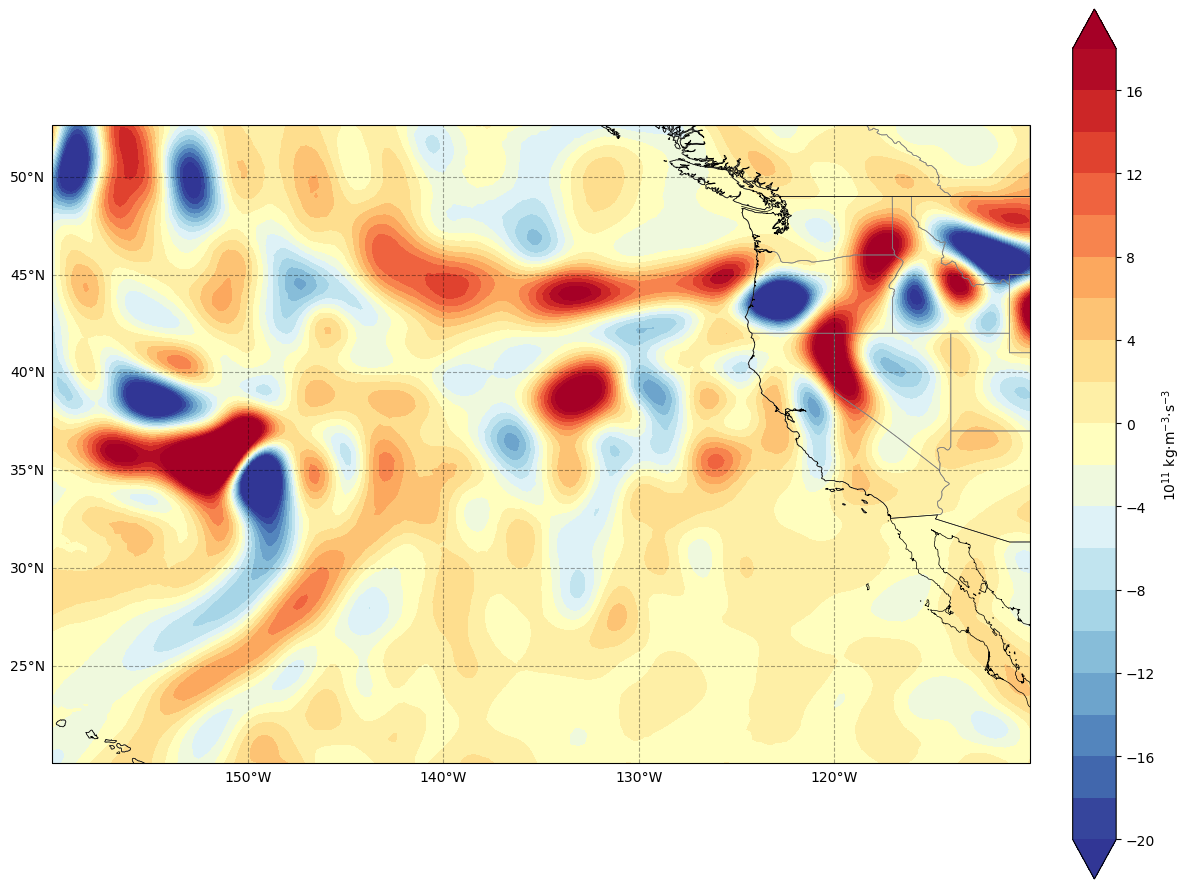

In [47]:
if __name__ == '__main__':
    directions = {'North': 55, 
                  'East': 250, 
                  'South': 20, 
                  'West': 200}
    g = 9.81 # units: m/s^2
    #plot_omega(g, ds_pl, directions)
    plot_omega2(g, ds_pl, directions)